In [4]:
import stim
from IPython.display import SVG

def rep_code(distance: int, rounds: int, noise: float) -> stim.Circuit:
    circuit = stim.Circuit()
    qubits = range(2*distance + 1)
    data = qubits[::2]
    measure = qubits[1::2]
    circuit.append_operation("X_ERROR" , data, noise)
    for m in measure:
        circuit.append_operation("CNOT" , [m-1, m])
    for m in measure:
        circuit.append_operation("CNOT" , [m+1, m])
    circuit.append_operation("MR" , measure)
    return circuit * rounds

distance=100
rounds=10
noise=0.01

circuit = rep_code(distance, rounds, noise)
sample = circuit.compile_sampler().sample(1)[0]   # shape = (2000,)
sample = sample.reshape(rounds, distance)  # rounds × distance

for r in sample:
    print("".join("_" if b == 0 else "1" for b in r))


____________________________________________________________________________________________________
____________________________________________________________________________________________________
_______________11____11_____________________________________________________________________________
_______________11____11____________________________________________________________________________1
_______________11____11______________________11__________11________________________________________1
_______________11____11______________________11__________11________________________________________1
_______________11____11______________11______11___11_____11_____________________________11_________1
_______11______11____11______________11______11___11_____11_____________________________11__11_____1
_______11______11__1111______________11______11___11_____11_____________________________11__11_____1
_______11______11__1111______________11______11___11_____11______________11_____________11_

REPEAT 10 {
    X_ERROR(0.05) 0 2 4 6 8 10
    CX 0 1 2 3 4 5 6 7 8 9 2 1 4 3 6 5 8 7 10 9
    MR 1 3 5 7 9
}
[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False  True  True False False False
   True  True]]
(1, 50)
round 01 syndrome: _11_______
round 01 e_hat   : __1________
round 02 syndrome: _11____11_
round 02 e_hat   : __1_____1__
round 03 syndrome: _11____11_
round 03 e_hat   : __1_____1__
round 04 syndrome: _11____11_
round 04 e_hat   : __1_____1__
round 05 syndrome: _11____11_
round 05 e_hat   : __1_____1__
final Pauli frame on data (tracked Xs):
frame: __X________


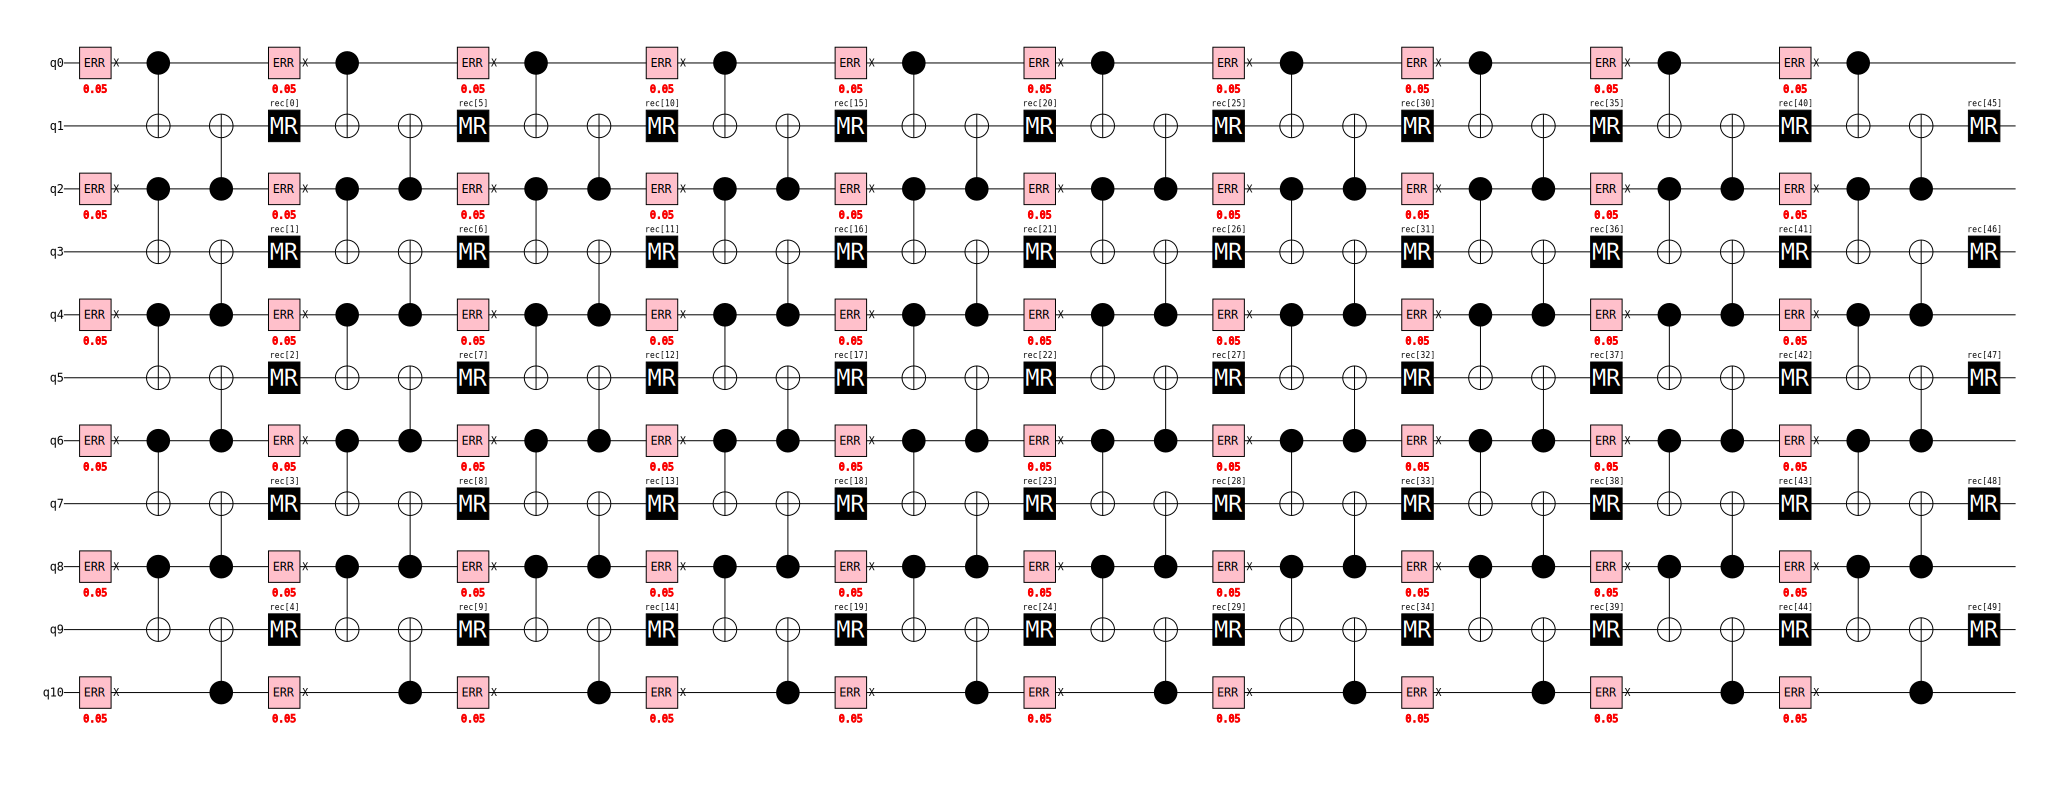

In [12]:
import stim

def rep_code(distance: int, rounds: int, noise: float) -> stim.Circuit:
    circuit = stim.Circuit()
    qubits = range(2*distance + 1)
    data = qubits[::2]
    measure = qubits[1::2]
    circuit.append_operation("X_ERROR" , data, noise)
    for m in measure:
        circuit.append_operation("CNOT" , [m-1, m])
    for m in measure:
        circuit.append_operation("CNOT" , [m+1, m])
    circuit.append_operation("MR" , measure)
    return circuit * rounds

distance=5
rounds=10
noise=0.05

circuit = rep_code(distance, rounds, noise)
print(circuit)
sample = circuit.compile_sampler().sample(1)
print(sample)
print(sample.shape)

def decode_min_weight_from_syndrome(s):
    """
    s: length d syndrome (Z_i Z_{i+1}) for a chain of n=d+1 data qubits.
    Returns a length-n estimate e_hat of X flips that PRODUCE s,
    chosen with minimal Hamming weight (Pauli frame update for this round).
    """
    d = len(s)
    n = d + 1
    # cumulative XOR from left boundary (assume left boundary parity = 0)
    e0 = [0]*n
    for i in range(1, n):
        e0[i] = e0[i-1] ^ int(s[i-1])
    w0 = sum(e0)
    # global flip symmetry: also valid is e1 = e0 ^ 1 (flip all data)
    e1 = [1 - x for x in e0]
    w1 = n - w0
    return e0 if w0 <= w1 else e1

def track_pauli_frame(distance: int, rounds: int, noise: float):
    circ = rep_code(distance, rounds, noise)
    shot = circ.compile_sampler().sample(1)[0]     # shape = (rounds*distance,)
    S = shot.reshape(rounds, distance)             # [round][check]
    n = distance + 1
    frame = [0]*n                                  # tracked Xs on data qubits

    for r in range(rounds):
        s = S[r]
        e_hat = decode_min_weight_from_syndrome(s)
        # Update tracked frame (no physical correction)
        frame = [a ^ b for a, b in zip(frame, e_hat)]
        # Pretty print: '_' for 0, '1' for detection bits
        print(f"round {r+1:02d} syndrome: " + "".join("_" if b == 0 else "1" for b in s))
        print(f"round {r+1:02d} e_hat   : " + "".join("_" if b == 0 else "1" for b in e_hat))

    print("final Pauli frame on data (tracked Xs):")
    print("frame: " + "".join("_" if b == 0 else "X" for b in frame))
    return frame, S

# Example
_ = track_pauli_frame(distance=10, rounds=5, noise=0.05)

SVG(str(circuit.flattened().diagram("timeline")))

In [ ]:
import stim

def rep_code_with_final_data(distance: int, rounds: int, noise: float) -> stim.Circuit:
    circuit = stim.Circuit()
    qubits = range(2*distance + 1)
    data = qubits[::2]
    meas = qubits[1::2]
    for _ in range(rounds):
        circuit.append_operation("X_ERROR", data, noise)
        for m in meas: circuit.append_operation("CNOT", [m-1, m])
        for m in meas: circuit.append_operation("CNOT", [m+1, m])
        circuit.append_operation("MR", meas)                  # distance bits/round
    circuit.append_operation("M", data)                       # final data readout (n=distance+1 bits)
    return circuit

def decode_min_weight_from_syndrome(s):
    d = len(s); n = d + 1
    e0 = [0]*n
    for i in range(1, n):
        e0[i] = e0[i-1] ^ int(s[i-1])
    w0 = sum(e0)
    return e0 if w0 <= n - w0 else [1 - x for x in e0]

def run_and_check(distance=5, rounds=5, noise=0.05):
    # Build & sample ONE shot
    circ = rep_code_with_final_data(distance, rounds, noise)
    rec = circ.compile_sampler().sample(1)[0]  # length = rounds*distance + (distance+1)

    d = distance
    n = d + 1
    # Split record: first rounds*d are syndromes; last n are final data
    syndromes = rec[: rounds * d].reshape(rounds, d)
    data_final = rec[rounds * d : ]

    # Track Pauli frame across rounds (no physical corrections)
    frame = [0]*n
    for r in range(rounds):
        s = syndromes[r]
        e_hat = decode_min_weight_from_syndrome(s)
        frame = [a ^ b for a, b in zip(frame, e_hat)]

    # Apply frame to final data measurement
    corrected_data = [(int(b) ^ f) for b, f in zip(data_final, frame)]

    # Majority vote (prep = |0>_L)
    raw_ones = sum(int(b) for b in data_final)
    cor_ones = sum(corrected_data)
    raw_logical = 1 if raw_ones > n//2 else 0
    cor_logical = 1 if cor_ones > n//2 else 0

    logical_error = (cor_logical != 0)  # expected 0 since we prepared |0>_L

    # Print a compact summary
    print(f"rounds={rounds}, distance={distance}, n={n}, noise={noise}")
    print("final data (raw):       " + "".join("1" if b else "_" for b in data_final))
    print("final Pauli frame (X):  " + "".join("X" if f else "_" for f in frame))
    print("final data (corrected): " + "".join("1" if b else "_" for b in corrected_data))
    print(f"raw logical = {raw_logical}, corrected logical = {cor_logical}")
    print("LOGICAL ERROR (after correction)?", logical_error)
    return {
        "syndromes": syndromes,
        "frame": frame,
        "data_final": data_final,
        "corrected_data": corrected_data,
        "raw_logical": raw_logical,
        "corrected_logical": cor_logical,
        "logical_error": logical_error
    }

# Example run
_ = run_and_check(distance=10, rounds=5, noise=0.1)


rounds=5, distance=10, n=11, noise=0.1
final data (raw):       _111____1_1
final Pauli frame (X):  ___X______X
final data (corrected): _11_____1__
raw logical = 0, corrected logical = 0
LOGICAL ERROR (after correction)? False
